In [1]:
from dask.distributed import Client, LocalCluster
import bokeh
import geopandas as gpd
import scipy
import libpysal
import momepy
import json
from dask import delayed
import glob
import dask
import dask.dataframe as dd
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import json
from tqdm import tqdm
from shapely.geometry import Point
import networkx as nx
import pickle
import time

/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/virgilxw/miniconda3/envs/morph_model_v1_tess/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
place = "glasgow"
local_crs = 27700

In [3]:
tessellation = gpd.read_parquet(f"./output/{place}/tessellation_p1.pq").to_crs(local_crs)
buildings = gpd.read_parquet(f"./output/{place}/buildings_scattere_scattered_p1.pq").to_crs(local_crs)
streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)

/tmp/ipykernel_16164/3257141034.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet(f"./output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)


In [4]:
streets

geometry
0       LINESTRING (281404.570 640811.019, 281363.760 ...
1       LINESTRING (281404.570 640811.019, 281367.172 ...
2       LINESTRING (281092.008 641238.306, 281081.228 ...
3       LINESTRING (284506.366 635214.170, 284439.381 ...
4       LINESTRING (282917.649 638658.697, 282915.719 ...
...                                                   ...
114336  LINESTRING (251562.191 667866.982, 251595.499 ...
114337  LINESTRING (251533.432 667893.981, 251562.191 ...
114338  LINESTRING (251587.083 667780.853, 251582.503 ...
114339  LINESTRING (251587.083 667780.853, 251601.246 ...
114340  LINESTRING (253396.709 674624.572, 253399.010 ...

[114341 rows x 1 columns]

In [5]:
buildings_meta = buildings

In [6]:
daskCluster = LocalCluster(threads_per_worker=1,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

client

2023-11-20 19:04:22,723 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-11-20 19:04:22,726 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-11-20 19:04:22,729 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-11-20 19:04:22,731 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-11-20 19:04:22,734 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-11-20 19:04:22,737 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-11-20 19:04:22,740 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-11-20 19:04:22,

<Client: 'tcp://127.0.0.1:39043' processes=8 threads=8, memory=250.47 GiB>

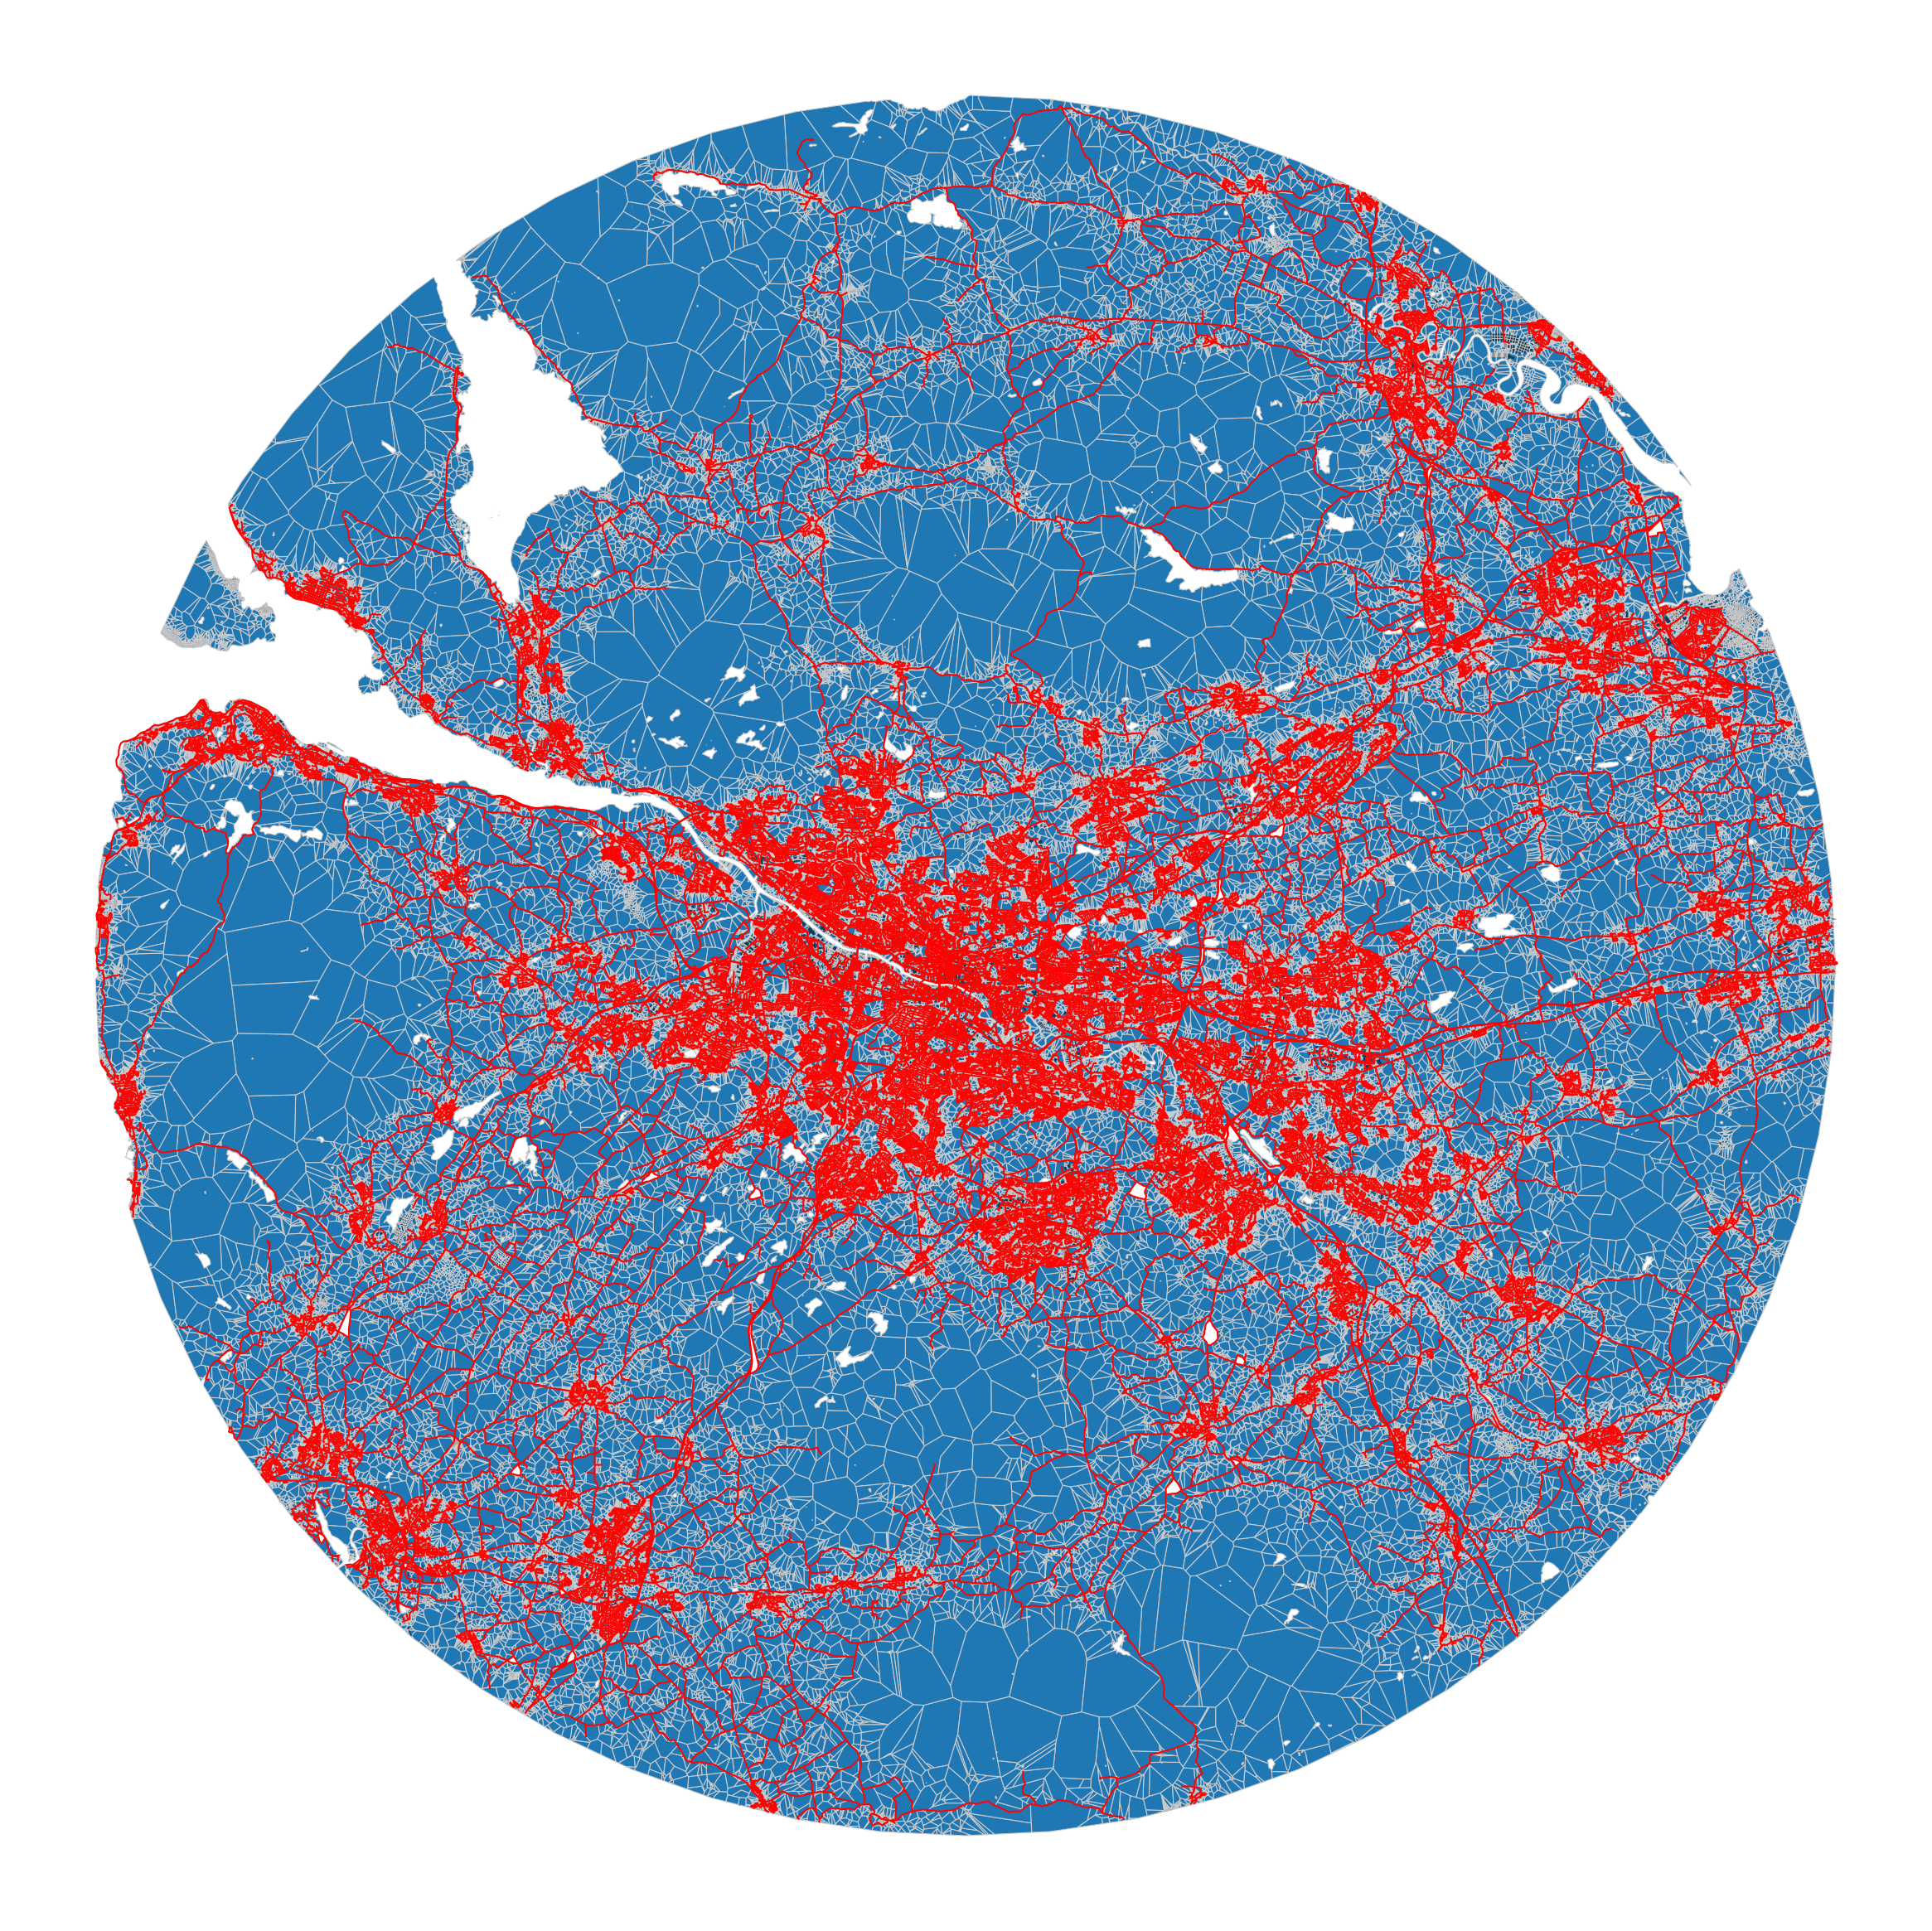

In [7]:
# Map for comparison
f, ax = plt.subplots(figsize=(30, 30))
tessellation.plot(linewidth=0.8, ax=ax, edgecolor='0.8')
streets.plot(ax=ax, color='red')
buildings.plot(ax=ax, color='black', alpha=0.5)
ax.set_axis_off()

# Show the plot
plt.show()

In [8]:
streets['nID'] = momepy.unique_id(streets)

In [9]:
### Building Area
buildings['building_area'] = momepy.Area(buildings).series
tessellation['tess_area'] = momepy.Area(tessellation).series

In [10]:
continuity = momepy.COINS(streets)

# streets["continuity_stroke"] = continuity.stroke_attribute()

In [11]:
stroke_attr = continuity.stroke_attribute()

In [12]:
stroke_gdf = continuity.stroke_gdf()

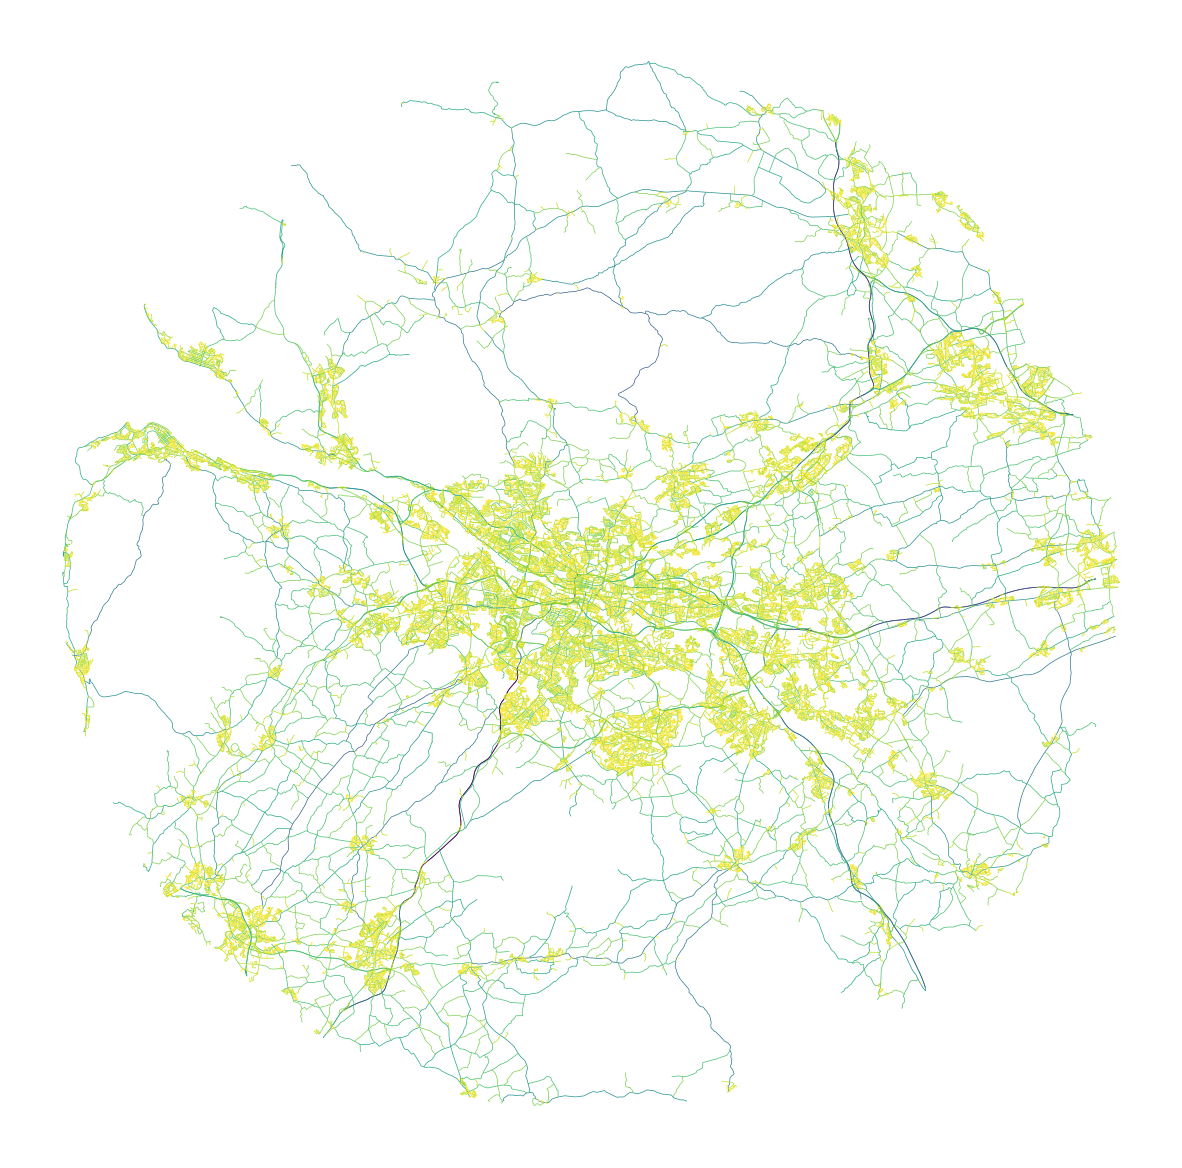

In [13]:
stroke_gdf.plot(stroke_gdf.length,
                figsize=(15, 15),
                cmap="viridis_r",
                linewidth=.5,
                scheme="headtailbreaks"
               ).set_axis_off()

In [ ]:
stroke_gdf.to_parquet(f"output/{place}/stroke_gdf.pq")

In [ ]:
buildings_scattered = dask.scatter(buildings)
streets_scattered = dask.scatter(streets)
tessellation_scattered = dask.scatter(tessellation)

dist200_scattered = dask.scatter(dist200)
queen_1_scattered = dask.scatter(queen_1)
queen_3_scattered = dask.scatter(queen_3)

In [ ]:
buildings_out = buildings

In [ ]:
%%time
# Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

jobs_names = ['building_circular_compactness', 'building_elongation', 'building_squareness', 'building_eri', 'building_orientation', "building_neighbour_dist", "building_neighbourhood_interbuilding_distance"]

jobs = [dask.delayed(momepy.CircularCompactness)(buildings_scattered), 
         dask.delayed(momepy.Elongation)(buildings_scattered), 
         dask.delayed(momepy.Squareness)(buildings_scattered),
         dask.delayed(momepy.EquivalentRectangularIndex)(buildings_scattered), 
         dask.delayed(momepy.Orientation)(buildings_scattered), 
         dask.delayed(momepy.NeighborDistance)(buildings_scattered, queen_1_scattered, 'uID'), 
         dask.delayed(momepy.MeanInterbuildingDistance)(buildings_scattered, queen_1_scattered, 'uID', 3)]

jobs_out = dask.compute(jobs)

# Assign the results back to the buildings GeoDataFrame
for index, field_name in enumerate(jobs_names):
    buildings_out[field_name] = jobs_out[index].series
    
buildings_scattered = dask.scatter(buildings_out)

In [ ]:
tessellation_out = tessellation

In [ ]:
%%time
# Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

jobs_names = ["tess_convexity", "tess_neighbours_200", "tess_covered_area", "tess_orientation", "tess_neighbours"]

jobs = [dask.delayed(momepy.Convexity)(tessellation_scattered), 
         dask.delayed(momepy.Neighbors)(tessellation_scattered, dist200_scattered, 'uID', weighted=True), 
         dask.delayed(momepy.CoveredArea)(tessellation_scattered, queen_1_scattered, "uID"),
         dask.delayed(momepy.Orientation)(tessellation_scattered), 
         dask.delayed(momepy.Neighbors)(tessellation_scattered, queen_3_scattered, 'uID', weighted=True)]

jobs_out = dask.compute(jobs)

# Assign the results back to the buildings GeoDataFrame
for index, field_name in enumerate(jobs_names):
    tessellation_out[field_name] = jobs_out[index].series

tessellation_scattered = dask.scatter(tessellation_out)

In [ ]:
%%time
# Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

jobs_names = ['building_circular_compactness_weight', 'building_elongation_weight', 'building_squareness_weight', 'building_eri_weight', "building_neighbour_dist_weight", "building_neighbourhood_interbuilding_distance_weight", 'building_orientation_weight']

jobs = [dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_circular_compactness',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
         dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_elongation',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
         dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_squareness',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
         dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_eri',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
         dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_neighbour_dist',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
         dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_neighbourhood_interbuilding_distance',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
         dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_orientation',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID')]

jobs_out = dask.compute(*jobs)

# Assign the results back to the buildings GeoDataFrame
for index, field_name in enumerate(jobs_names):
    buildings_out[field_name] = jobs_out[index].series

buildings_scattered = dask.scatter(buildings_out)

In [ ]:
%%time
# Assuming buildings_scattered is a GeoDataFrame and queen_1 is defined

jobs_names = ["tess_convexity_weight", "tess_covered_area_weight", "tess_orientation_weight", "tess_rea_theil", "building_neighbourhood_interbuilding_distance_weight"]

jobs = [dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                        values="tess_convexity",
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
         dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                        values='tess_covered_area',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
         dask.delayed(momepy.WeightedCharacter)(tessellation_scattered,
                                                        values='tess_orientation',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID'),
         dask.delayed(momepy.Theil)(tessellation_scattered, values='tess_area', spatial_weights=queen_3_scattered, unique_id='uID'),
         dask.delayed(momepy.WeightedCharacter)(buildings_scattered,
                                                        values='building_neighbourhood_interbuilding_distance_weight',
                                                        spatial_weights=queen_3_scattered,
                                                        unique_id='uID')]

jobs_out = dask.compute(*jobs)

# Assign the results back to the buildings GeoDataFrame
for index, field_name in enumerate(jobs_names):
    if index == len(jobs_names) - 1:  # Check if it's the last iteration
        buildings_out[field_name] = jobs_out[index].series
    else:
        tessellation_out[field_name] = tessellation[index].series

In [ ]:
streets_w_nid = streets
streets_w_nid["nID"]= streets.index
buildings_w_nid = gpd.sjoin_nearest(buildings_out, streets_w_nid, how="left", max_distance=50)

In [ ]:
%%time
buildings_w_nid["Building_Street_Alignment"] = momepy.StreetAlignment(buildings_w_nid, streets_w_nid,
                                   'building_orientation', 'nID',
                                   'nID').series

In [ ]:
buildings_out = buildings_out.merge(buildings_w_nid[['uID', 'Building_Street_Alignment']], on='uID', how='left')

In [ ]:
%%time
buildings_out['building_cell_align'] = momepy.CellAlignment(buildings_out, tessellation_out,
                                      'building_orientation', 'tess_orientation',
                                      'uID', 'uID').series

In [ ]:
buildings.to_parquet(f"output/{place}/buildings_tess.pq")
tessellation.to_parquet(f"output/{place}/tessellation_tess.pq")

In [ ]:
client.close()

: 